# We will read the data for first 60 days and then predict for the 61st day. Then we will hop ahead bt one day and read the next chunk of data for next sixty days.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('GOOG.csv', date_parser = True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4127,2021-01-11,1786.069946,1794.314941,1760.520020,1766.719971,1766.719971,1209700
4128,2021-01-12,1753.920044,1778.040039,1725.310059,1746.550049,1746.550049,1357700
4129,2021-01-13,1738.579956,1765.035034,1738.010010,1754.400024,1754.400024,1094100
4130,2021-01-14,1753.619995,1775.010010,1733.400024,1740.180054,1740.180054,1179500
4131,2021-01-15,1738.189941,1756.000000,1721.550049,1736.189941,1736.189941,1342200


Here we splitting the data into training and testing dataset. We are going to take data from 2004 to 2019 as training data. Subsequently we are going to take the data of 2020 as testing data.

In [3]:
data_training = data[data['Date']<'2020-01-01'].copy()
data_test = data[data['Date']>='2020-01-01'].copy()

In [4]:
data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)

In [5]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
data_training

array([[3.07080191e-04, 8.79291979e-04, 0.00000000e+00, 1.25356905e-04,
        5.43577404e-01],
       [6.89986513e-04, 2.78189186e-03, 1.73314228e-03, 3.15285500e-03,
        2.77885613e-01],
       [4.38255570e-03, 4.44951014e-03, 4.99709621e-03, 3.56690484e-03,
        2.22150736e-01],
       ...,
       [9.99726026e-01, 9.99642423e-01, 9.97425041e-01, 9.92923311e-01,
        1.24858240e-02],
       [9.89839738e-01, 9.90869803e-01, 9.85707361e-01, 9.80912804e-01,
        1.26372774e-02],
       [9.74702051e-01, 9.79457057e-01, 9.81925328e-01, 9.81583871e-01,
        1.15577171e-02]])

In [6]:
data_training.shape

(3869, 5)

In [9]:
data_training.shape[0]

3869

In [10]:
data_training[60, 0]

0.032618950097937284

In [11]:
data_training[59]

array([0.02651522, 0.03108214, 0.02733706, 0.03153236, 0.36440068])

In [12]:
data_training[60] #taking 0-59 in train and predicting opening price on 60th day

array([0.03261895, 0.03337511, 0.03108966, 0.0311449 , 0.40722445])

In [13]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train.shape

(3809, 60, 5)

# Building LSTM

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

The first layer is the LSTM layer with 60 units.
We will be using relu activation function.
The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.relu.png
return_sequence when set to True returns the full sequence as the output.
input_shape is set to (X_train.shape[1],5) which is (60,5)
Dropout layer is used to by randomly set the outgoing edges of hidden units to 0 at each update of the training phase.
The value passed in dropout specifies the probability at which outputs of the layer are dropped out.
The last layer is the Dense layer is the regular deeply connected neural network layer.
As we are predicting a single value the units in the last layer is set to 1.

In [17]:
regressor = Sequential()

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [18]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            15840     
_________________________________________________________________
dropout (Dropout)            (None, 60, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

Here we are compiling the model and fitting it to the training data. We will use 50 epochs to train the model. An epoch is an iteration over the entire data provided. batch_size is the number of samples per gradient update i.e. here the weights will be updates after 32 training examples.

In [19]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
120/120 [==============================] - 15s 129ms/step - loss: 0.0153
Epoch 2/50
120/120 [==============================] - 17s 142ms/step - loss: 0.0022
Epoch 3/50
120/120 [==============================] - 17s 143ms/step - loss: 0.0023
Epoch 4/50
120/120 [==============================] - 17s 138ms/step - loss: 0.0022
Epoch 5/50
120/120 [==============================] - 17s 138ms/step - loss: 0.0020
Epoch 6/50
120/120 [==============================] - 16s 136ms/step - loss: 0.0017
Epoch 7/50
120/120 [==============================] - 17s 140ms/step - loss: 0.0017
Epoch 8/50
120/120 [==============================] - 16s 131ms/step - loss: 0.0017
Epoch 9/50
120/120 [==============================] - 15s 127ms/step - loss: 0.0016
Epoch 10/50
120/120 [==============================] - 15s 127ms/step - loss: 0.0015
Epoch 11/50
120/120 [==============================] - 15s 128ms/step - loss: 0.0013
Epoch 12/50
120/120 [==============================] - 15s 125ms/step - lo

Prepare test dataset

These are the first 5 entries in the test data set. To predict opening on any day we need the data of previous 60 days

In [20]:
data_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
3869,2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1367.369995,1406600
3870,2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1360.660034,1186400
3871,2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
3872,2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
3873,2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000


past_60_days contains the data of the past 60 days required to predict the opening of the 1st day in the test data set.

In [25]:
data_train = data[data['Date']<'2020-01-01'].copy()
past_60_days = data_train.tail(60)

We are going to append data_test to past_60_days and ignore the index of data_test and drop Date and Adj Close.

In [26]:
df = past_60_days.append(data_test, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,1204.400024,1218.203979,1203.750000,1207.680054,842900
1,1197.589966,1206.079956,1189.010010,1189.130005,1039300
2,1199.349976,1208.349976,1197.630005,1202.310059,867700
3,1198.579956,1215.000000,1197.339966,1208.670044,846600
4,1222.209961,1228.390015,1213.739990,1215.449951,1272700


Similar to the training data set we have to scale the test data so that all the values are in the range 0 to 1.

In [27]:
inputs = scaler.transform(df)
inputs

array([[0.87902801, 0.88831029, 0.88587359, 0.88295285, 0.01011709],
       [0.87384509, 0.87908573, 0.87457744, 0.8688071 , 0.01249673],
       [0.87518458, 0.88081287, 0.88118346, 0.87885784, 0.01041758],
       ...,
       [1.28557615, 1.30436655, 1.29530926, 1.29986613, 0.0131607 ],
       [1.29702267, 1.31195601, 1.29177635, 1.28902238, 0.01419543],
       [1.28527932, 1.29749225, 1.282695  , 1.28597963, 0.01616675]])

In [28]:
#We have to prepare the test data like the training data.

In [29]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((263, 60, 5), (263,))

In [30]:
y_pred = regressor.predict(X_test)

As we had scaled all the values down, now we will have to get them back to the original scale. scaler.scale_ gives the scaling level

In [31]:
scaler.scale_

array([7.61069658e-04, 7.60849739e-04, 7.66360329e-04, 7.62571888e-04,
       1.21162775e-08])

8.186 is the first value in the list which gives the scale of opening price. We will multiply y_pred and y_test with the inverse of this to get all the values to the original scale.

In [32]:
scale = 1/7.61069658e-04
scale

1313.940175499678

In [33]:
y_pred = y_pred*scale
y_test = y_test*scale

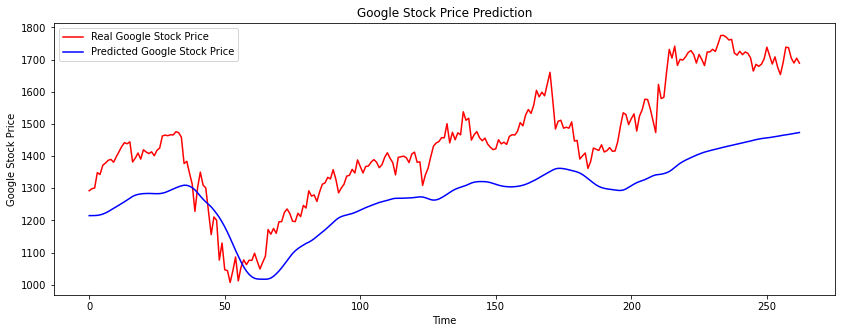

In [34]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()